In [ ]:
### v2.1 = experiments on the level of chapters and verses

In [2]:
### Prerequisties
# most of the packages are available via anaconda
# some of them require to be installed separately

# some of the packages (especially nltk) are necessary only for preprocessing
# feel free to ignore them and move directly into later sections

import os
import pandas as pd
import numpy as np
import nltk
import pickle
import json
import sys
import re

import csv
from bs4 import BeautifulSoup
import xml.etree.cElementTree as ET

from gensim import corpora, models, similarities
### drawing on a basic tutorial: https://radimrehurek.com/gensim/tut1.html#corpus-streaming-one-document-at-a-time
### we use it here basically only for generating the vector model

import numpy as np 
from sklearn.feature_extraction.text import CountVectorizer

### for plotting
import matplotlib.pyplot as plt

### for visualization
import plotly.plotly as py
import plotly.graph_objs as go
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
init_notebook_mode(connected=True)



# To work with the biblical books abbreviations only

# Vectorization on the level of verses 

In [3]:
### uploading the data
file = open("data/CSEL_PL_b_c_v.pkl", "rb")
CSEL_PL_bib_abbr = pickle.load(file)

### uploading the list of authors
file = open("data/authors_dict.pickle", "rb")
authors_dict = pickle.load(file)
authors_df = pd.DataFrame.from_dict(authors_dict, orient="index")

In [5]:
len(CSEL_PL_bib_abbr)

69

In [3]:
### we transform the list of abbreviations into a document term matrix using
### a) sklearn CountVectorizer: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
### b) some tools from gensim: gensim: https://radimrehurek.com/gensim/tut1.html

vec = CountVectorizer(min_df = 3)
X = vec.fit_transform(CSEL_PL_bib_abbr)
vectorization_df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
### to add there the names of authors
CSEL_PL_vectorization_df = pd.concat([authors_df[0], vectorization_df], axis=1)
# to save the vectorization data into a csv
CSEL_PL_vectorization_df.to_csv("data/CSEL_PL_vectorization.csv")
CSEL_PL_vectorization_df.head(5)

,0,acts_10_1,acts_10_10,acts_10_11,acts_10_13,acts_10_14,acts_10_15,acts_10_2,acts_10_25,acts_10_28,...,tit_1_9,tit_2_11,tit_2_13,tit_2_3,tit_2_6,tit_2_7,tit_3_10,tit_3_11,tit_3_5,tit_3_9
0,Ambrosius,0,1,1,0,1,2,0,0,0,...,0,0,0,0,0,1,3,0,5,0
1,Arnobius,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Augustinus,3,3,12,10,3,4,2,2,2,...,5,4,2,3,1,6,2,3,32,1
3,Aurelius Prudentius,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Boethius,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Similarity/Distance

In [4]:
### COSINE SIMILARITY
# https://en.wikipedia.org/wiki/Cosine_similarity
# as used here: https://de.dariah.eu/tatom/working_with_text.html#comparing-texts

from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_matrix = cosine_similarity(X.toarray())

### MATRIX WITHOUT ROW AND COLUMN NAMES
cosine_sim_df = pd.DataFrame(np.round(cosine_sim_matrix, 5))
cosine_sim_df.to_csv("data/cosine_sim.csv")
cosine_sim_df.to_pickle("data/cosine_sim.pkl")

### MATRIX WITH ROW AND COLUMN NAMES
cosine_sim_df_with_names = pd.concat([authors_df[0], cosine_sim_df], axis=1)
list_of_authors = authors_df[0].tolist()
list_of_authors.insert(0, "author")
cosine_sim_df_with_names.columns = list_of_authors
cosine_sim_df_with_names.to_csv("data/cosine_sim_with_names.csv")

# Networks

In [5]:
import networkx as nx
G = nx.Graph()
G.clear()

In [6]:
cosine_sim_array = pd.read_pickle("data/cosine_sim.pkl").as_matrix().astype(float)

/Users/vojtech/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [7]:
G=nx.from_numpy_matrix(cosine_sim_array)

In [8]:
# RENAME THE NODES

with open('data/authors_dict.pickle', 'rb') as handle:
    authors_dict = pickle.load(handle)

G = nx.relabel_nodes(G, authors_dict)

In [9]:
### REMOVE "unknown"
G.remove_node("unknown")

In [10]:
### REMOVE EDGES WITH IDENTICAL NODE SOURCE AND TARGET

# since networkx is unable to iterate over changing network, we need to separte the process into 2 steps
# (1) form a list of tuples, i.e. edges to remove 
edges_to_remove = []
for (u, v) in G.edges:
    if u == v:
        edges_to_remove.append((u, v))
# (2) iterate over the list and remove the edges from it one by one
for u_v_tuple in edges_to_remove:
    G.remove_edge(*u_v_tuple)

G.number_of_edges()

963

In [11]:
nx.write_gexf(G, "data/cosine_sim_total_network.gexf")

In [12]:
### REMOVE EDGES WITH WEIGHT UNDER CERTAIN VALUE

# since networkx is unable to iterate over changing network, we need to separte the process into 2 steps
# (1) form a list of tuples, i.e. edges to remove 

edges_to_remove = []
for (u, v, wt) in G.edges.data('weight'):
    if wt < 0.17:
        edges_to_remove.append((u, v))
        
# (2) iterate over the list and remove the edges from it one by one
for u_v_tuple in edges_to_remove:
    G.remove_edge(*u_v_tuple)

### REMOVE NODES WITHOUT EDGES
nodes_to_remove = []
for isolated_node in nx.isolates(G):
    nodes_to_remove.append(isolated_node)
for element in nodes_to_remove:
    G.remove_node(element)
    
### REMOVE NODES WITH LESS THAN TWO EDGES
nodes_to_remove = []
for node in G.nodes:
    if G.degree(node) < 2:
        nodes_to_remove.append(node)
for element in nodes_to_remove:
    G.remove_node(element)

print("Number of edges: ", G.number_of_edges(), ", number of nodes: ", G.number_of_nodes())

Number of edges:  127 , number of nodes:  28


In [13]:
nx.write_gexf(G, "data/cosine_sim_reduced_network.gexf")

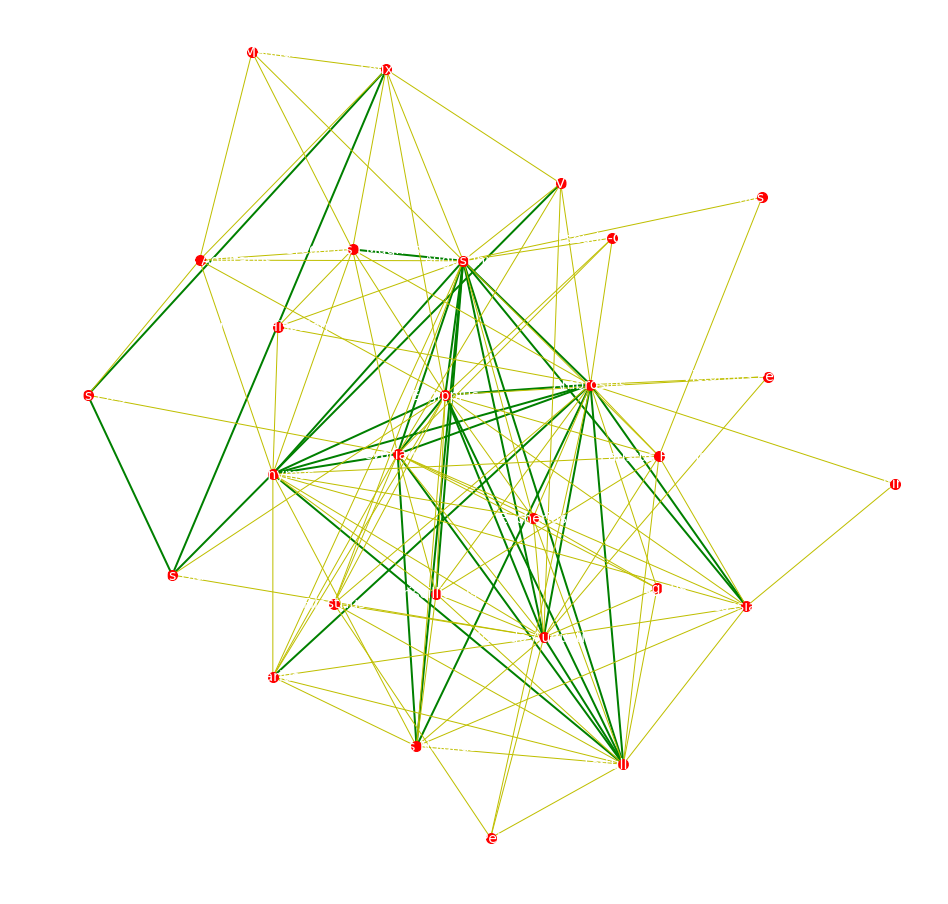

In [16]:
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.3]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <0.3]
plt.figure(figsize=(16, 16))
pos=nx.kamada_kawai_layout(G)

nx.draw_networkx_nodes(G,pos, nodecolor='r',  node_size=100)

nx.draw_networkx_edges(G,pos,edgelist=elarge, width=2,edge_color='g')
nx.draw_networkx_edges(G,pos,edgelist=esmall, width=1,edge_color='y')

nx.draw_networkx_labels(G,pos,font_size=14,font_family='sans-serif',font_color="white")
plt.axis('off')
plt.savefig("data/CSEL_PL_bibl_abbr_network.png")
plt.show()

# To work with the biblical books abbreviations only

# Vectorization on the level of chapters

In [17]:
### uploading the data
file = open("data/CSEL_PL_b_c.pkl", "rb")
CSEL_PL_bib_abbr = pickle.load(file)

### uploading the list of authors
file = open("data/authors_dict.pickle", "rb")
authors_dict = pickle.load(file)
authors_df = pd.DataFrame.from_dict(authors_dict, orient="index")

In [18]:
### we transform the list of abbreviations into a document term matrix using
### a) sklearn CountVectorizer: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
### b) some tools from gensim: gensim: https://radimrehurek.com/gensim/tut1.html

vec = CountVectorizer(min_df = 3)
X = vec.fit_transform(CSEL_PL_bib_abbr)
vectorization_df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
### to add there the names of authors
CSEL_PL_vectorization_df = pd.concat([authors_df[0], vectorization_df], axis=1)
# to save the vectorization data into a csv
CSEL_PL_vectorization_df.to_csv("data/CSEL_PL_vectorization_chapters.csv")
CSEL_PL_vectorization_df

,0,acts_1,acts_10,acts_11,acts_12,acts_13,acts_14,acts_15,acts_16,acts_17,...,sir_27,sir_29,sir_3,sir_32,sir_34,sir_9,tit_1,tit_2,tit_3,tit_5
0,Ambrosius,11,17,2,3,14,5,6,8,27,...,6,7,1,3,15,3,4,1,8,0
1,Arnobius,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Augustinus,129,118,16,9,18,10,19,15,56,...,0,0,0,0,0,0,55,39,50,0
3,Aurelius Prudentius,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Boethius,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Caius,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Cassianus,6,4,0,1,0,1,6,1,1,...,1,1,1,1,1,0,1,3,0,0
7,Claudianus Mamertus,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Commodianus,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
9,Concilia Carthaginensia,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Similarity/Distance

In [19]:
### COSINE SIMILARITY
# https://en.wikipedia.org/wiki/Cosine_similarity
# as used here: https://de.dariah.eu/tatom/working_with_text.html#comparing-texts

from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_matrix = cosine_similarity(X.toarray())

### MATRIX WITHOUT ROW AND COLUMN NAMES
cosine_sim_df = pd.DataFrame(np.round(cosine_sim_matrix, 5))
cosine_sim_df.to_csv("data/cosine_sim_chapters.csv")
cosine_sim_df.to_pickle("data/cosine_sim_chapters.pkl")

### MATRIX WITH ROW AND COLUMN NAMES
cosine_sim_df_with_names = pd.concat([authors_df[0], cosine_sim_df], axis=1)
list_of_authors = authors_df[0].tolist()
list_of_authors.insert(0, "author")
cosine_sim_df_with_names.columns = list_of_authors
cosine_sim_df_with_names.to_csv("data/cosine_sim_with_names_chapters.csv")

# Networks

In [20]:
import networkx as nx

G = nx.Graph()
G.clear()

In [21]:
cosine_sim_array = pd.read_pickle("data/cosine_sim_chapters.pkl").as_matrix().astype(float)

/Users/vojtech/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [22]:
G=nx.from_numpy_matrix(cosine_sim_array)

In [23]:
# RENAME THE NODES

with open('data/authors_dict.pickle', 'rb') as handle:
    authors_dict = pickle.load(handle)

G = nx.relabel_nodes(G, authors_dict)

In [24]:
### REMOVE "unknown"
G.remove_node("unknown")

In [25]:
### REMOVE EDGES WITH IDENTICAL NODE SOURCE AND TARGET

# since networkx is unable to iterate over changing network, we need to separte the process into 2 steps
# (1) form a list of tuples, i.e. edges to remove 
edges_to_remove = []
for (u, v) in G.edges:
    if u == v:
        edges_to_remove.append((u, v))
# (2) iterate over the list and remove the edges from it one by one
for u_v_tuple in edges_to_remove:
    G.remove_edge(*u_v_tuple)

G.number_of_edges()

1492

In [27]:
nx.write_gexf(G, "data/cosine_sim_total_network_chapters.gexf")

In [28]:
### REMOVE EDGES WITH WEIGHT UNDER CERTAIN VALUE

# since networkx is unable to iterate over changing network, we need to separte the process into 2 steps
# (1) form a list of tuples, i.e. edges to remove 

edges_to_remove = []
for (u, v, wt) in G.edges.data('weight'):
    if wt < 0.5:
        edges_to_remove.append((u, v))
        
# (2) iterate over the list and remove the edges from it one by one
for u_v_tuple in edges_to_remove:
    G.remove_edge(*u_v_tuple)

### REMOVE NODES WITHOUT EDGES
nodes_to_remove = []
for isolated_node in nx.isolates(G):
    nodes_to_remove.append(isolated_node)
for element in nodes_to_remove:
    G.remove_node(element)
    
### REMOVE NODES WITH LESS THAN TWO EDGES
nodes_to_remove = []
for node in G.nodes:
    if G.degree(node) < 2:
        nodes_to_remove.append(node)
for element in nodes_to_remove:
    G.remove_node(element)

print("Number of edges: ", G.number_of_edges(), ", number of nodes: ", G.number_of_nodes())

Number of edges:  114 , number of nodes:  29


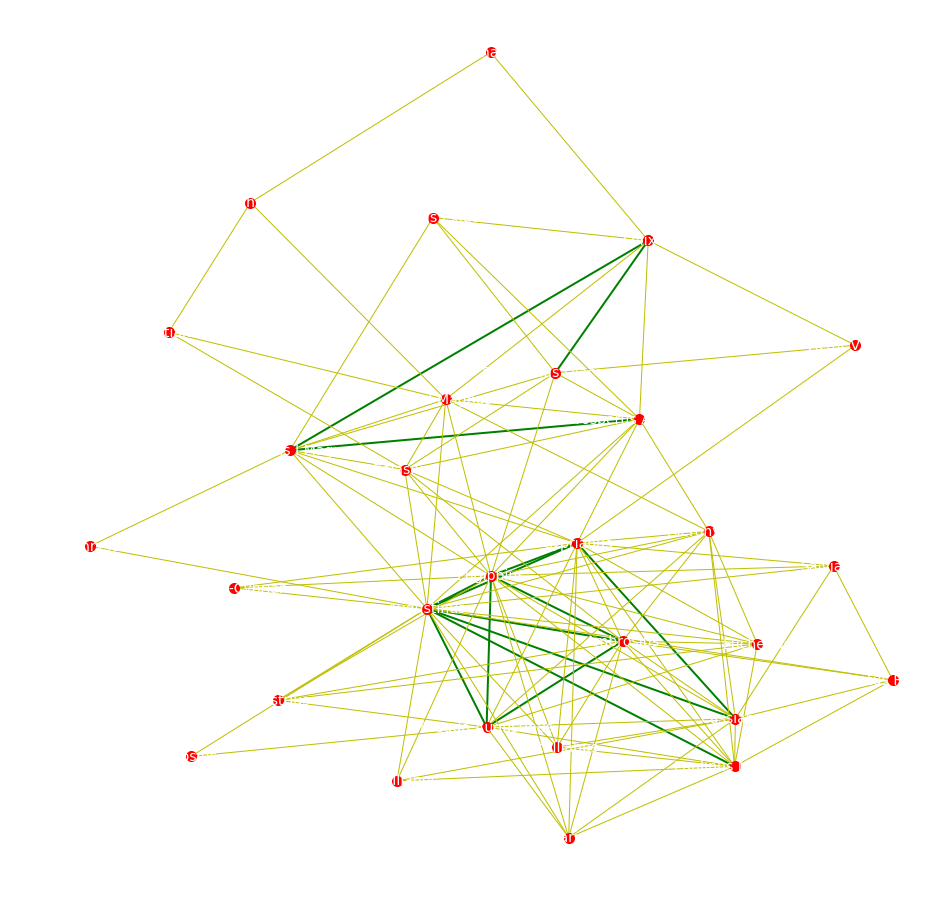

In [31]:
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.7]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <0.7]
plt.figure(figsize=(16, 16))
pos=nx.kamada_kawai_layout(G)

nx.draw_networkx_nodes(G,pos, nodecolor='r',  node_size=100)

nx.draw_networkx_edges(G,pos,edgelist=elarge, width=2,edge_color='g')
nx.draw_networkx_edges(G,pos,edgelist=esmall, width=1,edge_color='y')

nx.draw_networkx_labels(G,pos,font_size=14,font_family='sans-serif', font_color="white")
plt.axis('off')
plt.savefig("data/CSEL_PL_bibl_abbr_network_chapters.png")
plt.show()